## Семинар 6 "Segmentation"

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 14 ноября 2021). Скорее всего будут дополнительные плюшки для призеров конкурса.


In [2]:
!unzip -q "datasets.zip" -d "."
!unzip -q "test.zip" -d "."
!unzip -q "training" -d "."
!mkdir "./test/retult"

mapname:  conversion of  failed
replace ./test.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./training.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./test/images/01_test.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./test/images/02_test.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./test/images/03_test.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./test/images/04_test.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace ./test/images/04_test.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace ./training/1st_manual/21_manual1.gif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
mkdir: cannot create directory ‘./test/retult’: File exists


In [3]:
!pip install imagecodecs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.4 MB 483 kB/s 


In [4]:
import matplotlib.pyplot as plt

import torch as t
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms as tsf
import torch.nn as nn
from pathlib import Path

import torch
from torch import randn


device = "cuda"
torch.device(device)

import skimage
import skimage.transform
from skimage import io

import imageio
import PIL
TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline

In [5]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data
test = process('test/images/')
t.save(test, TEST_PATH)
train_data = process('training/images', "training/1st_manual/")

from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(train_data, test_size=0.1)

In [6]:
class Dataset():
    def __init__(self,data,source_transform,target_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.ToTensor(),]
)
dataset = Dataset(train_data,s_trans,t_trans)
valset = Dataset(val_data,s_trans,t_trans)
dataloader = t.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)
valloader = t.utils.data.DataLoader(valset, batch_size=4, shuffle=False)


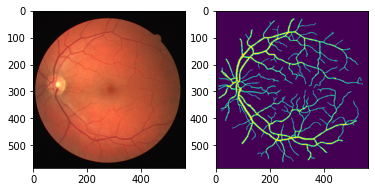

In [7]:
img,mask = dataset[12]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

In [8]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch) 

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x



class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = double_conv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = torch.sigmoid(x)
        return x

In [9]:
# Попробуйте использовать различные функции потерь.
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
    
class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=0.1, beta=0.9, gamma=3.0):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky
    

In [10]:
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(testset,batch_size=1)

In [11]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        X = X.to(device)
        y = y.to(device)  
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / num_batches
    return avg_loss
    
def test_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss = 0
    model.eval()
    
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)  
            output = model(X)
            total_loss += loss_function(output, y).item()
    avg_loss = total_loss / num_batches
    return avg_loss

In [16]:
loss_function = FocalTverskyLoss()

model = UNet(3, 1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

max_epochs = 100

In [17]:
train_focal_losses = []
train_dice_losses = []
val_focal_losses = []
val_dice_losses = []
for epoch in range(1, max_epochs + 1):
    print(f"epoch: {epoch}", end='\t')
    loss = train_model(dataloader, model, loss_function, optimizer=optimizer)
    train_focal_losses.append(loss)
    print("Loss/train(focal)", f"{loss:.4f}", end='\t')
    loss = test_model(dataloader, model, soft_dice_loss)
    train_dice_losses.append(loss)
    print("Loss/train(dice)", f"{loss:.4f}", end='\t')
    loss = test_model(valloader, model, loss_function)
    val_focal_losses.append(loss)
    print("Loss/val(focal)", f"{loss:.4f}", end='\t')
    loss = test_model(valloader, model, soft_dice_loss)
    val_dice_losses.append(loss)
    print("Loss/val(dice)", f"{loss:.4f}")


epoch: 1	Loss/train(focal) 0.1425	Loss/train(dice) 0.8392	Loss/val(focal) 0.2621	Loss/val(dice) 0.8438
epoch: 2	Loss/train(focal) 0.0836	Loss/train(dice) 0.8161	Loss/val(focal) 0.1980	Loss/val(dice) 0.8218
epoch: 3	Loss/train(focal) 0.0659	Loss/train(dice) 0.8117	Loss/val(focal) 0.1899	Loss/val(dice) 0.8141
epoch: 4	Loss/train(focal) 0.0553	Loss/train(dice) 0.7999	Loss/val(focal) 0.1397	Loss/val(dice) 0.7976
epoch: 5	Loss/train(focal) 0.0489	Loss/train(dice) 0.7853	Loss/val(focal) 0.1336	Loss/val(dice) 0.7934
epoch: 6	Loss/train(focal) 0.0429	Loss/train(dice) 0.8005	Loss/val(focal) 0.1208	Loss/val(dice) 0.7986
epoch: 7	Loss/train(focal) 0.0393	Loss/train(dice) 0.7656	Loss/val(focal) 0.0776	Loss/val(dice) 0.7651
epoch: 8	Loss/train(focal) 0.0378	Loss/train(dice) 0.7363	Loss/val(focal) 0.0685	Loss/val(dice) 0.7408
epoch: 9	Loss/train(focal) 0.0349	Loss/train(dice) 0.7424	Loss/val(focal) 0.0682	Loss/val(dice) 0.7405
epoch: 10	Loss/train(focal) 0.0327	Loss/train(dice) 0.7101	Loss/val(focal

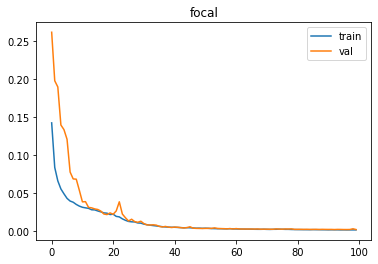

In [24]:
plt.plot(train_focal_losses, label="train")
plt.plot(val_focal_losses, label="val")
plt.title("focal")
plt.legend()
plt.show()

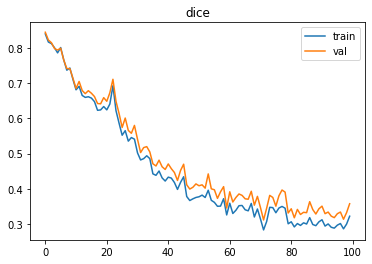

In [25]:
plt.plot(train_dice_losses, label="train")
plt.plot(val_dice_losses, label="val")
plt.title("dice")
plt.legend()
plt.show()

In [18]:
torch.save(model, "afterFocalTversky")

In [26]:
model = torch.load("afterFocalTversky")

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_dice_losses = []
val_dice_losses = []
for epoch in range(max_epochs + 1, max_epochs + 10 + 1):
    print("epoch: ", epoch, end='\t')
    loss = train_model(dataloader, model, DiceLoss(), optimizer=optimizer)
    train_dice_losses.append(loss)
    print("Loss/train(dice)", loss, end="\t")
    loss = test_model(valloader, model, DiceLoss())
    val_dice_losses.append(loss)
    print("Loss/val(dice)", loss)

epoch:  101	Loss/train(dice) 0.2668920397758484	Loss/val(dice) 0.2434806227684021
epoch:  102	Loss/train(dice) 0.24382307529449462	Loss/val(dice) 0.2638668417930603
epoch:  103	Loss/train(dice) 0.23931410312652587	Loss/val(dice) 0.24242109060287476
epoch:  104	Loss/train(dice) 0.23678672313690186	Loss/val(dice) 0.25162792205810547
epoch:  105	Loss/train(dice) 0.23460822105407714	Loss/val(dice) 0.25372886657714844
epoch:  106	Loss/train(dice) 0.23006622791290282	Loss/val(dice) 0.24319815635681152
epoch:  107	Loss/train(dice) 0.23280255794525145	Loss/val(dice) 0.23933255672454834
epoch:  108	Loss/train(dice) 0.2294858932495117	Loss/val(dice) 0.2426682710647583
epoch:  109	Loss/train(dice) 0.22759561538696288	Loss/val(dice) 0.23996031284332275
epoch:  110	Loss/train(dice) 0.2241773009300232	Loss/val(dice) 0.24305999279022217


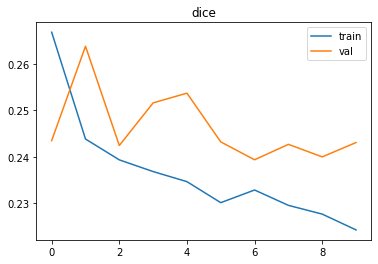

In [28]:
plt.plot(train_dice_losses, label="train")
plt.plot(val_dice_losses, label="val")
plt.title("dice")
plt.legend()
plt.show()

In [ ]:
model = model.eval()
with torch.no_grad():
    for ex_id, data in enumerate(testdataloader):
        data = data.to(device)
        o = model(data)
        
        source_image = io.imread("./test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
        tm = o[0][0].data.cpu().numpy()
        tm = skimage.transform.resize(tm, source_image.shape[:-1])
        tm = (tm > 0.5).astype(int)
        
        imageio.imwrite("./test/retult/%s.png" % (ex_id + 1), tm)

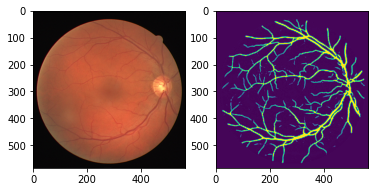

In [ ]:
tm=o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm)

In [ ]:
!zip -r "./result.zip" "./test/retult"

updating: test/retult/ (stored 0%)
updating: test/retult/10.png (deflated 1%)
updating: test/retult/13.png (deflated 1%)
updating: test/retult/17.png (deflated 1%)
updating: test/retult/15.png (deflated 1%)
updating: test/retult/7.png (deflated 1%)
updating: test/retult/12.png (deflated 1%)
updating: test/retult/16.png (deflated 1%)
updating: test/retult/19.png (deflated 1%)
updating: test/retult/1.png (deflated 1%)
updating: test/retult/14.png (deflated 1%)
updating: test/retult/8.png (deflated 1%)
updating: test/retult/3.png (deflated 1%)
updating: test/retult/2.png (deflated 1%)
updating: test/retult/6.png (deflated 1%)
updating: test/retult/9.png (deflated 1%)
updating: test/retult/5.png (deflated 1%)
updating: test/retult/18.png (deflated 1%)
updating: test/retult/4.png (deflated 1%)
updating: test/retult/20.png (deflated 1%)
updating: test/retult/11.png (deflated 1%)


984th	sphere_VictorDotZ 	14 Dec. 2022	0.8062


Сначала попробовал ради мемов TernausNet (Unet с энкодером VGG предобученном на imagenet, первый в своем роде), он конечно сегментировал, но не то что было нужно

Затем попробовал FocalLoss на предложенном Unet

Попробовал добавить вращений и гауссовского шума, но в итоге отказался от аугментации, т.к. в тесте данные крайне похожи на те что в трейне

Также отказался от ресайза изображений, т.к. переехал в колаб и тут много VRAM

В конце остановился на обучении сначала этого Unet с FocalTverskyLoss, подсмотрел в статье параметры 0.1 и 0.9 как дающие норм specificity и sensitivity, гамму 3 взял из соображения что должно получится чёткое разделение образно на черный/белый, затем дообучил DiceLoss'ом, что помогло убрать "мусор", очистить предсказание от вкроплений "белого" -- похожий подход с дообучением знаком из работы по сегментации дефектов дорожного покрытия, что очень близко к данной задаче
